# Определение фронтира

**Фронтир** - некоторая фундаментальная концепция, являющася точкой ростой множества прикладных исследований
и их последующей успешной коммерциализации.

*Пример - глубокое обучение.*

## Подготовительный код получения вложений статей arxiv

1. С kaggle можно взять датасет статей arxiv.org, почистить-причесать немного,
2. С помощью сетки allenai/scibert - насчитать вложения для  абстрактов статей,

Работает в Google Colab **_Pro_**.

In [1]:
!pip install umap-learn transformers==4.6.1 keybert

     |████████████████████████████████| 81kB 5.1MB/s 
     |████████████████████████████████| 2.3MB 45.8MB/s 
     |████████████████████████████████| 1.2MB 44.3MB/s 
     |████████████████████████████████| 901kB 53.7MB/s 
     |████████████████████████████████| 3.3MB 63.7MB/s 
     |████████████████████████████████| 81kB 11.8MB/s 
     |████████████████████████████████| 1.2MB 39.0MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=3574058ba4259cfb0269c7bdc104387c904a4d0ae7bc72f7d73e52b7940026e2
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for keybert: filename=keybert-0.3.0-cp37-none-any.whl size=19436 sha256=01a2b76fce15f430578d248d0e41ab7cd0a2fc02c213fb4847cdbffda6f88408
  Stored in directory: /root/.cache/pip/wheels/0c/ab/2b/bc129895ee956866333f364f1b3beb20efa788e074c03e6b34
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51

In [153]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import umap

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from scipy.signal import find_peaks

from sklearn.utils import shuffle
from datetime import date

import tensorflow as tf
import keras
from IPython.display import clear_output

import torch
from transformers import AutoTokenizer, AutoModel

from sklearn.cluster import AgglomerativeClustering

import keybert

import gc
import os

from tqdm import tqdm

In [3]:
%%time

# https://www.kaggle.com/Cornell-University/arxiv
all_papers = pd.read_json(
    '/content/drive/MyDrive/data/arxiv-metadata-oai-snapshot.json',
    lines=True
)

def extract_created(value):
  return value[0]['created']

all_papers['created'] = all_papers['versions'].apply(extract_created)

CPU times: user 50.1 s, sys: 11.7 s, total: 1min 1s
Wall time: 1min 28s


In [4]:
%%time

needed_columns = ['created', 'abstract', 'title', 'categories']
papers = all_papers[needed_columns].copy()

# подмножество всех статей
subset = 40 * 1000

papers['date'] = pd.to_datetime(papers.created.values)
papers = papers[papers['date'] >= '2009-01-01']

indices = shuffle(np.arange(len(papers)), random_state=1)[:subset]
papers = papers.iloc[indices].copy()

if 'all_papers' in globals():
  del all_papers
gc.collect();

CPU times: user 4min 19s, sys: 1.26 s, total: 4min 20s
Wall time: 4min 19s


In [5]:
papers.date.describe().T

count                         40000
unique                        39976
top       2012-03-15 11:17:56+00:00
freq                              5
first     2009-01-02 12:47:47+00:00
last      2021-05-27 17:34:31+00:00
Name: date, dtype: object

In [6]:
cuda_tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased', use_fast=True)
cuda_model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')
cuda_model.to('cuda:0');

def inference(texts_list):
  data = cuda_tokenizer(texts_list, truncation=True, padding=True, max_length=400, return_tensors='pt')
  for key in data:
    data[key] = data[key].cuda()
  return cuda_model(**data)['pooler_output'].detach().cpu().numpy()

def infer(sliced):
  return inference(papers['abstract'].values[sliced].tolist())

step = 200
embeddings = None

for index in tqdm(range(0, len(papers), step), position=0, leave=True):
  torch.cuda.empty_cache()
  with torch.no_grad():
    current = infer(slice(index, index + step))
  if embeddings is None:
    embeddings = current
  else:
    embeddings = np.concatenate([embeddings, current])
  gc.collect()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 200/200 [09:40<00:00,  2.90s/it]


In [7]:
assert len(embeddings) == len(papers)
print('ok')

ok


# Код обучения и проверки

Идея идентификации фронтиров заключена в следующем:
1. Вкладываем с помощью `UMAP` подвыборку всех вложений абстрактов в двумерное пространство,
2. Кластеризуем,
3. Берем биржевые индексы отраслей США (с finam.ru),
4. Для них строим таргет: от даты время до пика, величина пика,
5. Учим простую сетки для каждого индекса, на входе средние компоненты после `umap` по всем кластерам (сколько бы их ни было) на дату, и усредненные за `history` последних дней arxiv, на выходе - таргет (дата до пика и величина пика - два выхода),
6. Для определения наиболее повлиявшего кластера проворачиваем ~~фарш~~ градиенты в обратную сторону (почти `grad-cam`, но проще),
7. Какой индекс дал наибольший вклад - тот "папа"-кластер. Смотрим что в него входит, какие абстракты - все конкатенируем,
8. Извлекаем облако слов и получаем некоторое описание фронтира.

In [71]:
path = '/content/drive/MyDrive/data/finam/'

def get_target_data(window=180, start_date='2010-01-01', end_date='2022-01-01'):
  ticker_files = [
    filename for filename in os.listdir(path) if filename.endswith('.csv')
  ]

  result = {}
  name_slice = slice(8, 12)

  for file in ticker_files:
    frame = pd.read_csv(path + file, parse_dates=['<DATE>'])
    frame = frame.dropna()
    frame['<CLOSE>'] = frame['<CLOSE>'].apply(lambda value: '.'.join(str(value).split('.')[:2])).astype(np.float)
    series = frame.set_index('<DATE>')['<CLOSE>'].resample('1D').interpolate().sort_index()
    series = series[series.index >= start_date]
    series = series[series.index < end_date]
    series = series.rolling(window=window, center=True).mean().dropna()
    result[file[name_slice]] = series

  result = pd.DataFrame(result)
  result['US22'] = result.mean(axis=1)

  return result

# возвращает пару (дней до пика, величина пика)
def get_pair(serie, width=40):
  peaks = find_peaks(serie, width=width)[0]
  if len(peaks):
    return [
      (serie.index[peaks[0]] - serie.index[0]).days, serie[peaks[0]]
    ]
  else:
    return None

In [272]:
%%time

def map_and_cluster(n_clusters=100):
  mapper = umap.UMAP(
    n_neighbors=5, min_dist=0.01, n_components=3, metric='cosine',
    random_state=1
  )
  
  timed_embeddings = np.copy(embeddings)
  timed_embeddings[:, -1] = np.array(indices) / (2 * 1000 * 1000)

  mapped = mapper.fit_transform(timed_embeddings)

  clusterer = AgglomerativeClustering(
      n_clusters=n_clusters, memory='/tmp/'
  ).fit(mapped)

  return mapped, clusterer

mapped, clusterer = map_and_cluster()

CPU times: user 1min 41s, sys: 2.68 s, total: 1min 44s
Wall time: 1min 36s


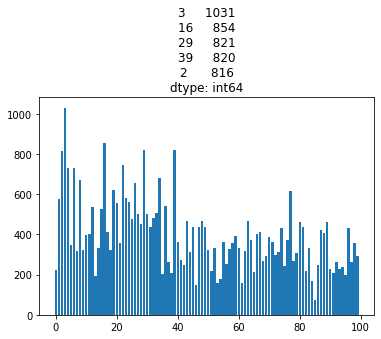

In [273]:
plt.title('%s' % pd.value_counts(clusterer.labels_)[:5])
plt.bar(
    pd.value_counts(clusterer.labels_).index, pd.value_counts(clusterer.labels_).values
);

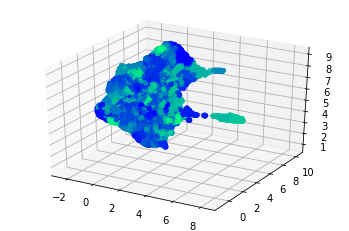

In [274]:
axes = plt.subplot(projection='3d')
axes.scatter(
    mapped[:, 0],
    mapped[:, 1],
    mapped[:, 2],
    c=clusterer.labels_,
    cmap='winter'
);

In [275]:
# начинаем делать данные для обучения

dataset = papers.copy()
dataset['umap_0'] = mapped[:, 0]
dataset['umap_1'] = mapped[:, 1]
dataset['umap_2'] = mapped[:, 2]
dataset['cluster'] = clusterer.labels_

data = dataset.set_index('date').sort_index()[
  ['umap_0', 'umap_1', 'umap_2', 'cluster']
]

# выкидываем торговые войны и COVID-19
end_date = '2018-10-01'
data = data[data.index <= end_date]

'Количество вложенных в 3D статей', len(data)

('Количество вложенных в 3D статей', 27209)

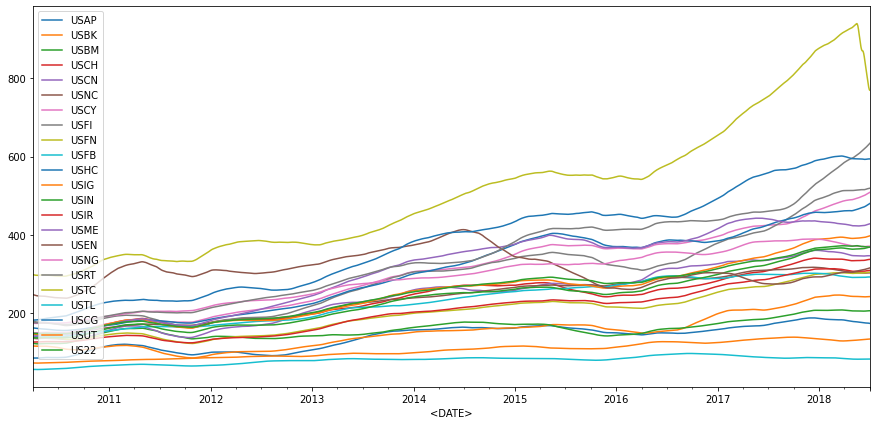

In [276]:
target = get_target_data(end_date=end_date)
target.plot(figsize=(15, 7));

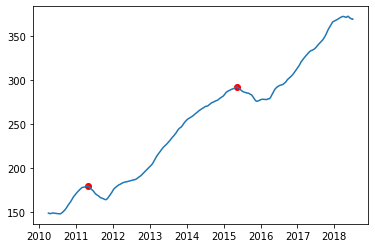

In [277]:
check_day, check_peak = get_pair(target['US22'])
plt.plot(target['US22'].index, target['US22'].values);
plt.scatter(target['US22'].index[check_day], check_peak, c='red');
check_day_next, check_peak = get_pair(target['US22'][check_day:])
plt.scatter(target['US22'].index[check_day + check_day_next], check_peak, c='red');

In [278]:
# сгрупируем маппинги статей кластеров на дату
# и сделаем каждый кластер колонкой из 3-х значений
# назовем их umap_i_j, i - номер компоненты, j - номер кластера

grouped = data.groupby(['date', 'cluster'])[['umap_0', 'umap_1', 'umap_2']].mean().reset_index()
grouped = grouped.pivot(index='date', columns=['cluster'], values=['umap_0', 'umap_1', 'umap_2']).fillna(0).reset_index()
grouped.columns = ["_".join([str(pair[0]), str(pair[1])]) for pair in grouped.columns]

In [279]:
gc.collect()
# насчитаем для тренировки X и y

# сколько последних компонент UMAP усреднять
history = 100

mapped_columns = list(grouped.columns)
mapped_columns.remove('date_')

clusters_number = len(data.cluster.unique())
X_ = grouped[mapped_columns].values

X = []
y_ = {indicator: [] for indicator in target.columns}
target_dates = {}

for indicator in tqdm(y_, position=0, leave=True):
  values = target[indicator].copy()
  indexed = []
  for check in values.index:
    if len(grouped.date_ == check.tz_localize('UTC')) > 0:
      indexed.append(check)
  values = values[np.isin(values.index, indexed)]
  target_dates[indicator] = values.index.copy()
  for index in range(history, len(values)):
    pair = get_pair(values[index:])
    if pair is None:
      continue
    # X насчитываем один раз
    if indicator == 'US22':
      X_array = np.array(X_[index - history:index]).reshape(history, -1)
      X_array = np.mean(X_array, axis=0)
      X.append(X_array.tolist())
    y_[indicator].append(pair)

X = np.array(X).reshape(-1, clusters_number * 3)
y = {
  key: np.array(y_[key]).reshape(len(y_[key]), -1) for key in y_
}

print()
print('X shape', X.shape, 'indicator shape', y['USAP'].shape)

100%|██████████| 23/23 [00:26<00:00,  1.15s/it]


X shape (2776, 300) indicator shape (2675, 2)


Всё, учим наши сеточки

In [289]:
def create_model():
  model = keras.Sequential([
    keras.layers.Dense(128, input_shape=(clusters_number * 3,), activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2, activation='linear')
  ])

  model.compile('adam', 'mse')
  return model

In [290]:
def train(indicator, training):
  keras.backend.clear_session()
  gc.collect()

  y_mean = y[indicator][:training].mean(axis=0)
  y_std = y[indicator][:training].std(axis=0)

  target_y = (y[indicator] - y_mean) / y_std
  length = min([training, len(X), len(target_y)])

  model = create_model()
  model.fit(
      *shuffle(X[:length], target_y[:length], random_state=1),
      batch_size=100,
      epochs=100,
      verbose=False
  );
  return model, y_mean, y_std

In [282]:
def gradient_importance(x, model):
    x = tf.Variable(np.array(x).reshape(-1, clusters_number * 3), dtype=tf.float32)

    gradient_model = keras.Model(model.inputs, model.output)

    with tf.GradientTape() as tape:
        y = gradient_model(x)

    return tape.gradient(y, x).numpy()

def get_clusters(importances, top=1):
  sorts = np.argsort(importances.flatten())[-top:]
  return [
    index % clusters_number for index in sorts
  ]

def cluster_description(indicator, index, check_clusters, keyer):
  date_start = target_dates[indicator][index].tz_localize('UTC') - pd.Timedelta(days=history)
  date_end = target_dates[indicator][index].tz_localize('UTC')
  chosen_papers = dataset[(np.isin(dataset.cluster, check_clusters)) & (
    (date_start <= dataset.date) & (dataset.date <= date_end) 
  )][-history:]
  texts = ' '.join(chosen_papers.abstract.apply(
      lambda string: string.replace('\n', ' ')
  ).values.tolist())
  keywords = keyer.extract_keywords(
    texts, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=40
  )
  return keywords

In [283]:
# заведем отсечку

holdout = 200
training = len(X) - holdout
training

2576

In [243]:
def mean_absolute_percentage_error(y_true, y_pred): 
  try:
    return np.mean(np.abs((y_true[y_true != 0] - y_pred[y_true != 0]) / y_true[y_true != 0])) * 100
  except:
    return -1

In [291]:
metrics = []
gc.collect()

for indicator in y:
  entry = {}
  model, y_mean, y_std = train(indicator, training)
  model.save('/content/drive/MyDrive/data/' + indicator + '.h5')
  entry['indicator'] = indicator
  entry['mean_days'] = y_mean[0]
  entry['std_days'] = y_std[0]
  entry['mean_value'] = y_mean[1]
  entry['std_value'] = y_std[1]
  min_length = min([len(X), len(y[indicator])])
  entry['days_test_mae'] = mean_absolute_error(
      y[indicator][min_length-holdout:min_length, 0],
      y_std[0] * model.predict(X[min_length-holdout:min_length])[:, 0] + y_mean[0]
  )
  entry['value_test_mae'] = mean_absolute_error(
      y[indicator][min_length-holdout:min_length, 1],
      y_std[1] * model.predict(X[min_length-holdout:min_length])[:, 1] + y_mean[1]
  )
  entry['days_test_mape'] = mean_absolute_percentage_error(
      y[indicator][min_length-holdout:min_length, 0],
      y_std[0] * model.predict(X[min_length-holdout:min_length])[:, 0] + y_mean[0]
  )
  entry['value_test_mape'] = mean_absolute_percentage_error(
      y[indicator][min_length-holdout:min_length, 1],
      y_std[1] * model.predict(X[min_length-holdout:min_length])[:, 1] + y_mean[1]
  )
  print(indicator, entry)
  metrics.append(entry)

metrics = pd.DataFrame(metrics)

USAP {'indicator': 'USAP', 'mean_days': 315.0407608695652, 'std_days': 198.388459517199, 'mean_value': 153.59387369134842, 'std_value': 27.3667520443525, 'days_test_mae': 84.01764381408691, 'value_test_mae': 10.300333215740666, 'days_test_mape': 137.9070134837323, 'value_test_mape': 5.4815009862227}
USBK {'indicator': 'USBK', 'mean_days': 618.6436335403727, 'std_days': 440.75728735550564, 'mean_value': 180.77915658251354, 'std_value': 27.857663396670148, 'days_test_mae': 289.9158186340332, 'value_test_mae': 40.609313612008584, 'days_test_mape': 319.62557077275665, 'value_test_mape': 16.490856103206927}
USBM {'indicator': 'USBM', 'mean_days': 461.702251552795, 'std_days': 305.35637248718587, 'mean_value': 181.94925534847337, 'std_value': 22.77126466671616, 'days_test_mae': 322.57585273742677, 'value_test_mae': 8.555086415255714, 'days_test_mape': 289.5905606539267, 'value_test_mape': 4.107802400824363}
USCH {'indicator': 'USCH', 'mean_days': 407.9623447204969, 'std_days': 264.3994699609

In [292]:
indicators_map = {
    'US22': 'Average 22 Indicators',
    'USAP': 'Automobiles & Parts',
    'USBK': 'Banks',
    'USBM': 'Basic Materials',
    'USCH': 'Chemicals',
    'USCN': 'Construction & Materials',
    'USNC': 'Consumer Goods',
    'USCY': 'Consumer Services',
    'USFI': 'Financial Services',
    'USFN': 'Financials',
    'USFB': 'Food & Beverages',
    'USHC': 'Health Care',
    'USIG': 'Industrial Goods & Services',
    'USIN': 'Industrials',
    'USIR': 'Insurance',
    'USME': 'Media',
    'USEN': 'Oil & Gas',
    'USNG': 'Personal & Household Goods',
    'USRT': 'Retail',
    'USTC': 'Technology',
    'USTL': 'Telecommunications',
    'USCG': 'Travel & Leisure',
    'USUT': 'Utilities'
}

metrics_info = metrics.copy().fillna(-1).sort_values('value_test_mape')
metrics_info['details'] = metrics_info['indicator'].apply(lambda name: indicators_map[name])
metrics_info

indicator   mean_days  ...  value_test_mape                      details
10      USHC  587.631676  ...         0.167006                  Health Care
7       USFI  712.662844  ...         0.178787           Financial Services
15      USEN  401.794029  ...         0.292154                    Oil & Gas
17      USRT  354.508211  ...         0.296491                       Retail
6       USCY  615.116431  ...         0.302142            Consumer Services
21      USUT  312.008540  ...         0.408235                    Utilities
19      USTL  302.807453  ...         0.525601           Telecommunications
14      USME  585.308230  ...         0.955244                        Media
5       USNC  528.578804  ...         1.497325               Consumer Goods
16      USNG  712.446817  ...         1.627007   Personal & Household Goods
4       USCN  472.807842  ...         2.196529     Construction & Materials
3       USCH  407.962345  ...         2.257151                    Chemicals
9       USFB  742.703416  ...         2.385495             Food & Beverages
13      USIR  678.932453  ...         3.064012                    Insurance
2       USBM  461.702252  ...         4.107802              Basic Materials
0       USAP  315.040761  ...         5.481501          Automobiles & Parts
12      USIN  685.447205  ...         6.110548                  Industrials
8       USFN  694.836957  ...         6.644378                   Financials
22      US22  710.132764  ...         7.109326        Average 22 Indicators
11      USIG  685.153339  ...        10.331480  Industrial Goods & Services
1       USBK  618.643634  ...        16.490856                        Banks
20      USCG  471.715062  ...        18.915286             Travel & Leisure
18      USTC  445.201863  ...        25.025030                   Technology

[23 rows x 10 columns]

In [293]:
metrics.to_json('/content/drive/MyDrive/data/metrics.json', orient='records', lines=True)
# metrics

In [297]:
metrics = pd.read_json('/content/drive/MyDrive/data/metrics.json', lines=True)

check_indicator = 'USBK'
check_model = keras.models.load_model('/content/drive/MyDrive/data/' + check_indicator + '.h5')

def postprocess(model, array, indicator):
  line = metrics[metrics['indicator'] == indicator]
  predictions = model.predict(array)
  return (
    (line['mean_days'].values[0] + line['std_days'].values[0] * predictions[:, 0]),
    (line['mean_value'].values[0] + line['std_value'].values[0] * predictions[:, 1])
  )

print('days and value of peak', postprocess(check_model, X[-1:], check_indicator))

days and value of peak (array([220.98047], dtype=float32), array([170.72609], dtype=float32))


In [248]:
class CustomEmbedder(keybert.backend.BaseEmbedder):
  def embed(self, documents, verbose=False):
    gc.collect()
    torch.cuda.empty_cache()
    with torch.no_grad():
      data = cuda_tokenizer(documents, truncation=True, padding=True, max_length=400, return_tensors='pt')
      for key in data:
        data[key] = data[key].cuda()
      result = cuda_model(**data)['pooler_output'].detach().cpu().numpy()
    gc.collect()
    torch.cuda.empty_cache()
    return result

keyer = keybert.KeyBERT(model=CustomEmbedder())

In [298]:
check_clusters = get_clusters(gradient_importance(X[-1], check_model))
print(cluster_description(check_indicator, -1, check_clusters, keyer))

[('hump pulse', 0.5511), ('topological semimetals', 0.526), ('pulse represents', 0.5103), ('iterative integration', 0.4882), ('implies tsirelson', 0.4705), ('maintaining shape', 0.466), ('bispectrum signals', 0.427), ('mesh curved', 0.4139), ('requires mesh', 0.412), ('oscillatory bispectrum', 0.4003), ('using discretized', 0.4002), ('large number', 0.3952), ('primordial bispectrum', 0.3889), ('qubit systems', 0.3863), ('time t_s', 0.3617), ('principle', 0.3601), ('based hybrid', 0.3589), ('light landauer', 0.3483), ('mesh', 0.3427), ('curved triangles', 0.3427), ('nature', 0.3424), ('evidence', 0.3412), ('characteristic', 0.3406), ('localized hump', 0.3391), ('bispectrum presented', 0.3387), ('horne shimony', 0.3386), ('impractical avoid', 0.3383), ('embodied landauer', 0.3382), ('high frequency', 0.3378), ('tsirelson bound', 0.3358), ('nonlinear weyl', 0.3351), ('hump', 0.3345), ('computational viewpoint', 0.3268), ('holt', 0.3261), ('hump initial', 0.3241), ('massive particles', 0.3

In [299]:
check_clusters = get_clusters(gradient_importance(X[-history], check_model))
print(cluster_description(check_indicator, -history, check_clusters, keyer))

[('convex domains', 0.5201), ('infinite graphs', 0.5117), ('large probability', 0.5012), ('demonstrate schaefer', 0.4946), ('schaefer', 0.4914), ('question', 0.4912), ('vilenkin martingale', 0.4897), ('ackel', 0.4882), ('schr odinger', 0.482), ('relating jacobi', 0.4775), ('bochner riesz', 0.472), ('probabilistic representations', 0.4689), ('compact manifolds', 0.4677), ('analytic functions', 0.4665), ('martingales', 0.4653), ('investigate boundedness', 0.461), ('collective behavior', 0.4605), ('convex functions', 0.4592), ('hardy spaces', 0.4579), ('prove boundedness', 0.4542), ('partial sums', 0.4525), ('2q odd', 0.4521), ('propagation chaos', 0.4506), ('sufficient conditions', 0.449), ('point theorem', 0.4449), ('results pointed', 0.4446), ('integral operator', 0.4343), ('elliptic operators', 0.4341), ('sums martingale', 0.4295), ('lie algebra', 0.429), ('methods', 0.427), ('explicit bounds', 0.427), ('mathbb', 0.4265), ('odinger operators', 0.4253), ('maximal bochner', 0.4247), ('m

# Код для production

In [300]:
def create_description(indicator, index, predictor):
  days, value = postprocess(predictor, X[index:index+1], indicator)
  days = days[0]
  value = value[0]
  clusters = get_clusters(gradient_importance(X[index], model))
  wordcloud = cluster_description(indicator, index, clusters, keyer)
  date = target_dates[indicator][index]
  return {
      'date': str(date),
      'words': list(map(lambda pair: list(pair), wordcloud)),
      'days': days,
      'value': value
  }

create_description('USME', -history, check_model)

{'date': '2018-03-26 00:00:00',
 'days': 637.05414,
 'value': 435.05737,
 'words': [['pruning hashnet', 0.5356],
  ['based fpgas', 0.4769],
  ['neural networks', 0.4699],
  ['networks computationally', 0.4696],
  ['understanding segregation', 0.4548],
  ['expensive hashednets', 0.4489],
  ['neural network', 0.4477],
  ['implementing fpga', 0.4451],
  ['methodologically', 0.4426],
  ['effectively compress', 0.4408],
  ['conventional lte', 0.4361],
  ['adversarial perturbation', 0.436],
  ['seamlessly compress', 0.4342],
  ['pruning', 0.4295],
  ['using generative', 0.4188],
  ['large batch', 0.4177],
  ['methods', 0.417],
  ['deepthin networks', 0.4153],
  ['methods reaching', 0.4152],
  ['hashednets', 0.4142],
  ['higher throughput', 0.4099],
  ['convolutional neural', 0.4028],
  ['handling', 0.3957],
  ['proper alignment', 0.3918],
  ['multiple networks', 0.3911],
  ['using probabilistic', 0.3866],
  ['large hessian', 0.3849],
  ['sram based', 0.3799],
  ['validate feasibility', 0.379

In [301]:
data_step = 30
len(X), len(X) // data_step

(2776, 92)

In [302]:
result_data = {}

for indicator in tqdm(y, position=0, leave=True):
  current_model = keras.models.load_model('/content/drive/MyDrive/data/' + check_indicator + '.h5')
  result_data[indicator] = []
  for current in range(0, len(X), data_step):
    result_data[indicator].append(
        create_description(indicator, current, current_model)
    )

100%|██████████| 23/23 [48:30<00:00, 126.55s/it]


In [303]:
frame = pd.DataFrame(result_data)
frame.to_json('/content/drive/MyDrive/data/result_data_v2.json')

In [304]:
target.to_json('/content/drive/MyDrive/data/target_data_v2.json')

In [305]:
metrics_info.to_json('/content/drive/MyDrive/data/metrics_data_v2.json')